# CS285 Fall 2022 Homework 5

@ Author Juanwu Lu

@ Date  Nov-14-22

&copy; UC Berkeley

In [27]:
from __future__ import annotations

import os
import os.path as osp
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorboard as tb

plt.style.use('seaborn-paper')
sns.set_style('whitegrid')
# csv_root = '/mnt/c/Users/Dave/Downloads/cs285_hw5_csv/'
csv_root = 'data/hw5'

In [2]:
# Common Tensorboard Data Preprocessing function
def _process_df(df: pd.DataFrame, name: str = None) -> None:
    assert ('Step' in df.columns) and ('Value' in df.columns)
    df.sort_values(by=['Step'], inplace=True)
    df.rename(
        columns={'Step': 'Time Step', 'Value': name or 'Value'},
        inplace=True
    )
    if 'Wall time' in df.columns:
        df.drop(labels=['Wall time'], axis=1, inplace=True)

## Problem 1: "Unspervised" RND and exploration performance

- <input type="checkbox" checked> Implement the RND algorithm
- <input type="checkbox" checked> Use the `argmax` policy regarding exploration critic to generate state-action tuples
- <input type="checkbox" checked> __Pick two of the three envs and compare RND exploration to random one__
- <input type="checkbox" checked> Implement a separate exploration strategy of your own choice.

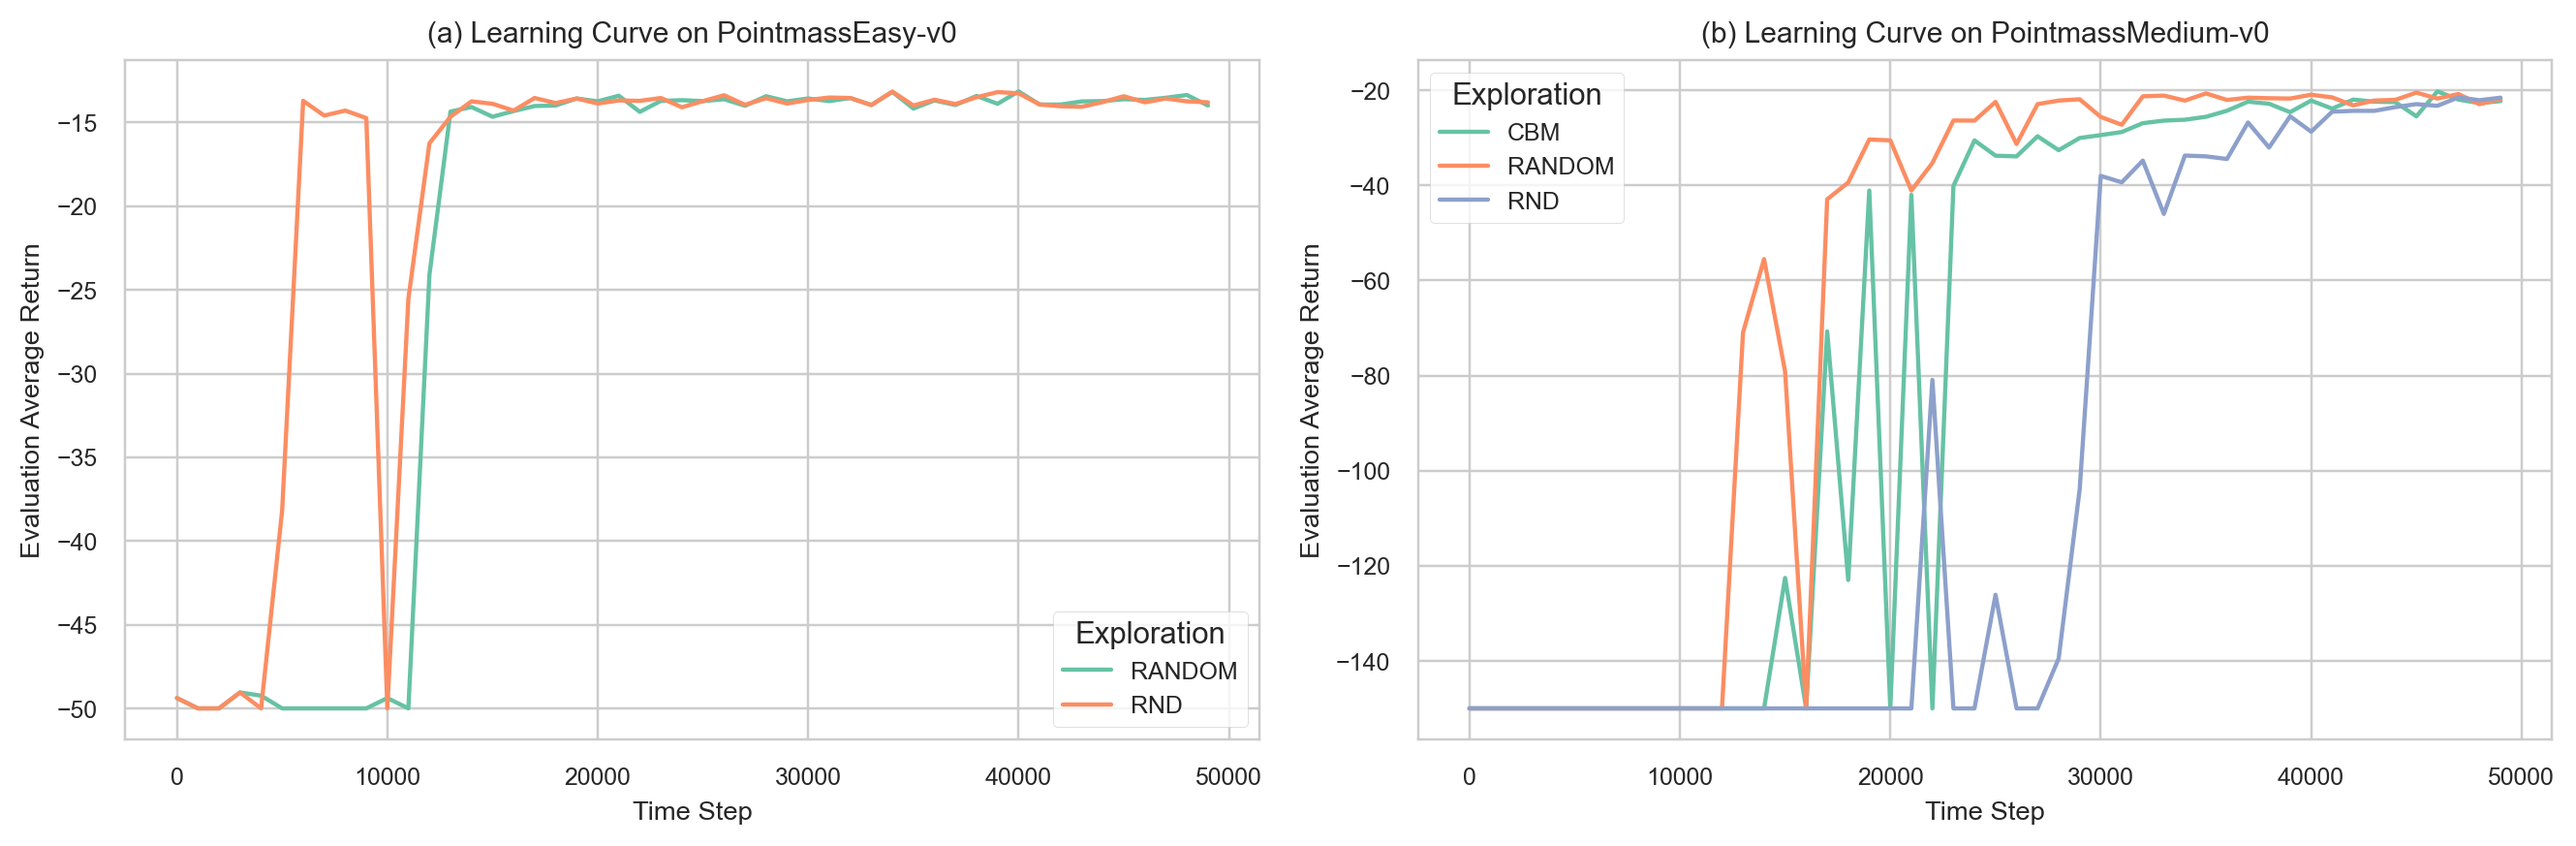

In [4]:
index_map = defaultdict(list)
for file in os.listdir(osp.join(csv_root, 'q1')):
    env_name = file.split('_')[5]
    alg_name = file.split('_')[4]
    index_map[env_name].append([alg_name, file])

fig, axes = plt.subplots(1, len(index_map),
                         dpi=224, figsize=(6 * len(index_map), 4))
for i, env_name in enumerate(index_map):
    df_list = []
    for alg, file in index_map[env_name]:
        df = pd.read_csv(osp.join(csv_root, 'q1', file),
                         sep=',', encoding='utf-8')
        _process_df(df, 'Evaluation Average Return')
        df['Exploration'] = alg.upper()
        df_list.append(df)
    data = pd.concat(df_list).sort_values(by='Exploration')
    axes[i] = sns.lineplot(data=data,
                           x='Time Step',
                           y='Evaluation Average Return',
                           hue='Exploration',
                           palette='Set2',
                           ax=axes[i])
    axes[i].set_title(f'({chr(97 + i)}) Learning Curve on {env_name:s}')

fig.tight_layout()
fig.savefig('../docs/hw5_report/img/q1_learning_curve.png', dpi=600)

## Problem 2: Offline learning on exploration data

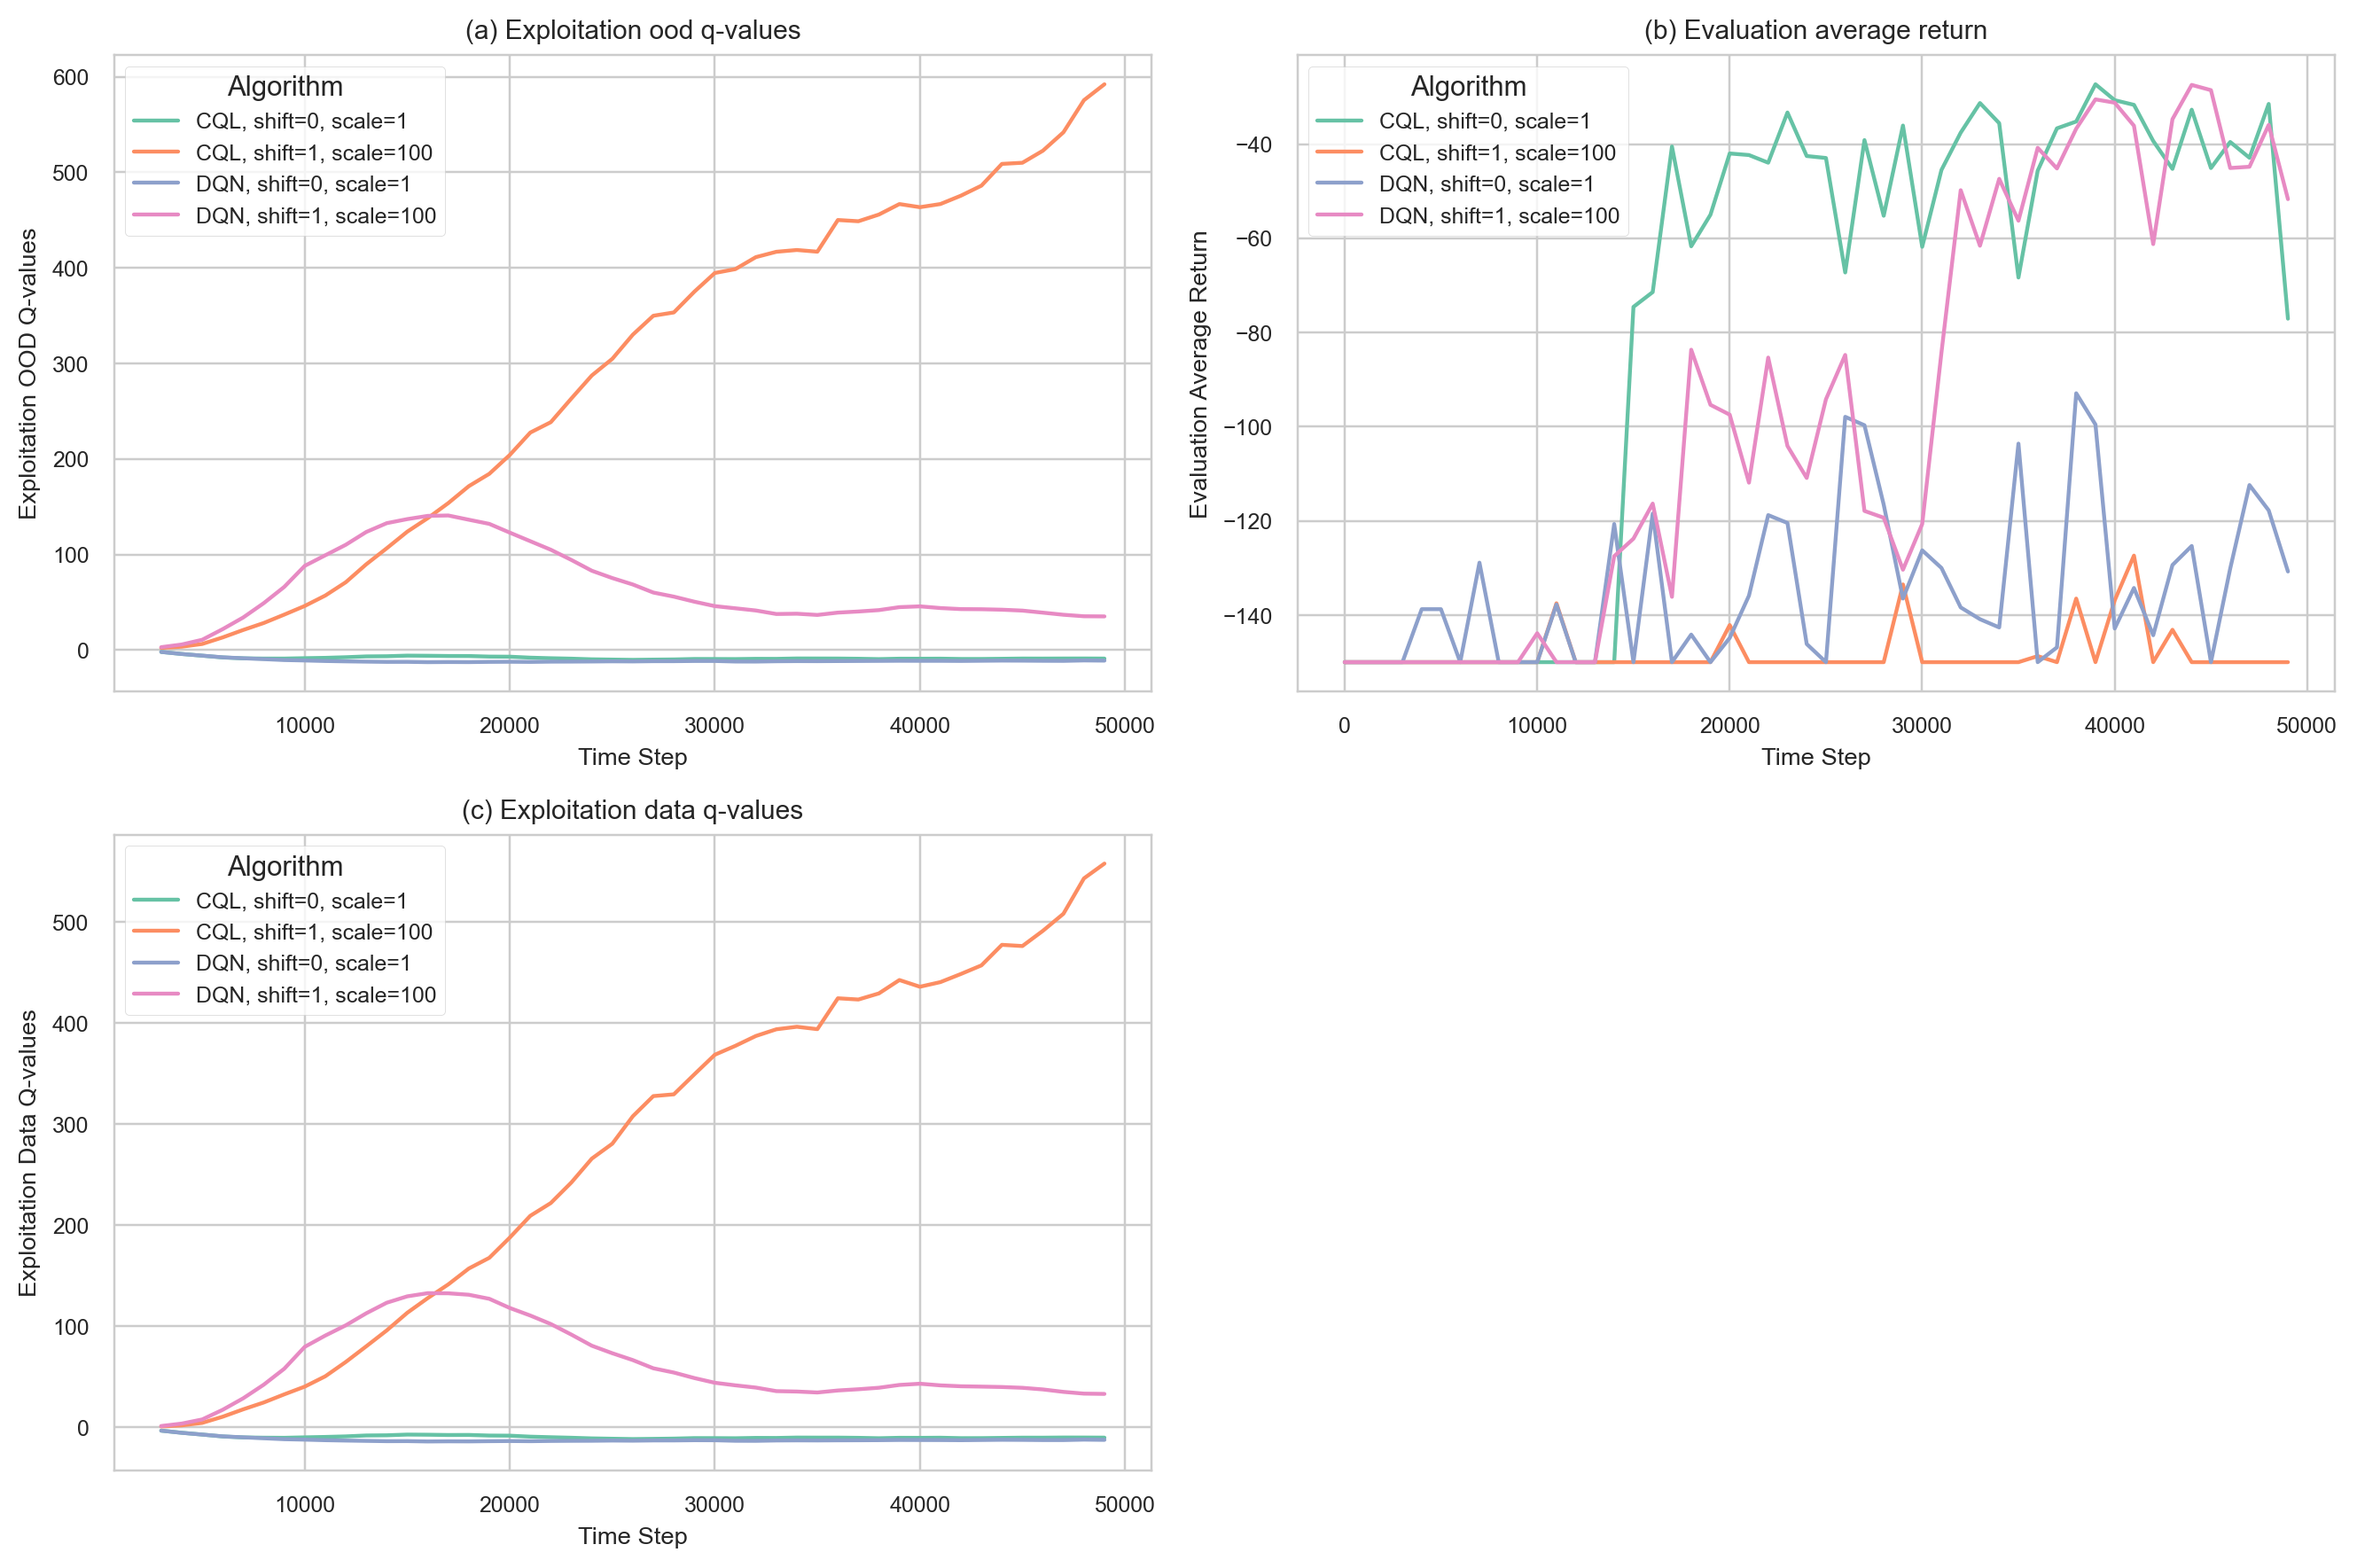

In [46]:
# Part 1
index_map = defaultdict(list)
for file in os.listdir(osp.join(csv_root, 'q2', 'part_1')):
    if file == '.DS_Store':
        continue
    alg_name = file.split('_')[3]
    if file.split('_')[4] == 'shift':
        shift_and_scale = True
    else:
        shift_and_scale = False
    attribute = file.split('.')[0].split('tag-')[1]
    attribute = attribute.replace('q', 'Q').replace('_', ' ')
    index_map[attribute].append([alg_name, shift_and_scale, file])

fig = plt.figure(figsize=(12, 8), dpi=224)
for i, attr in enumerate(index_map):
    ax = fig.add_subplot(2, 2, i + 1)
    df_list = []
    for alg, sas, file in index_map[attr]:
        df = pd.read_csv(osp.join(csv_root, 'q2', 'part_1', file),
                         sep=',', encoding='utf-8')
        _process_df(df, attr)
        df['Algorithm'] = alg.upper() + (', shift=1, scale=100' if sas \
                                         else ', shift=0, scale=1')
        df_list.append(df)
    data = pd.concat(df_list).sort_values(by='Algorithm')
    ax = sns.lineplot(data=data, x='Time Step', y=attr,
                      hue='Algorithm', palette='Set2', ax=ax)
    ax.set_title(f'({chr(97 + i)}) {attr.capitalize()}')

fig.tight_layout()
fig.savefig(f'../docs/hw5_report/img/q2_1.png', dpi=600)

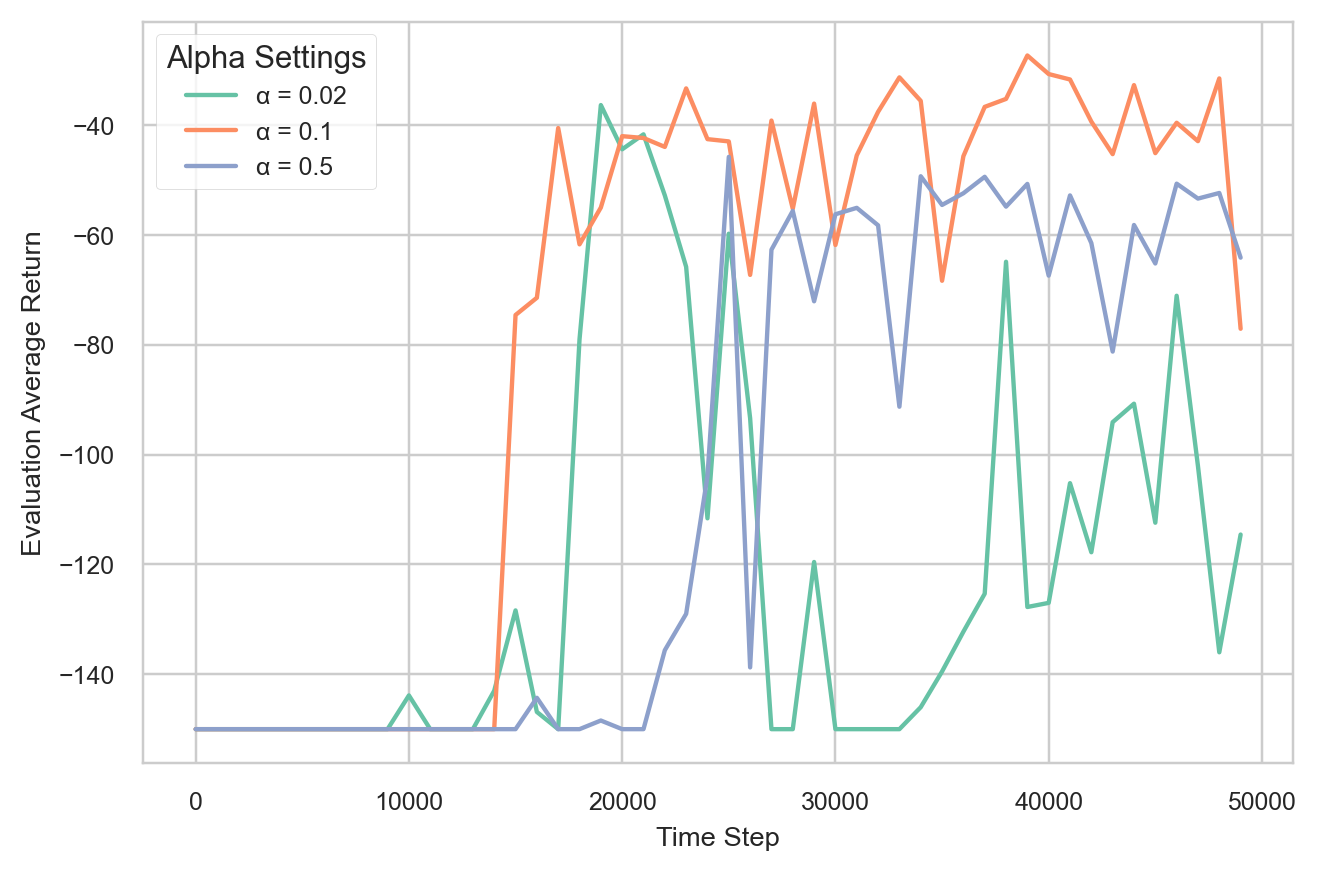

In [25]:
# Part 3
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=224)
df_list = []
for file in os.listdir(osp.join(csv_root, 'q2', 'part_3')):
    df = pd.read_csv(osp.join(csv_root, 'q2', 'part_3', file),
                        sep=',', encoding='utf-8')
    _process_df(df, 'Evaluation Average Return')
    alpha = file.split('_')[4]
    df['Alpha Settings'] = 'α = ' + alpha
    df['alpha'] = float(alpha)
    df_list.append(df)
data = pd.concat(df_list).sort_values(by='alpha')
ax = sns.lineplot(data=data,   
                  x='Time Step',
                  y='Evaluation Average Return',
                  hue='Alpha Settings',
                  palette='Set2',
                  ax=ax)

fig.tight_layout()
fig.savefig(f'../docs/hw5_report/img/q2_3.png', dpi=600)

## Problem 3: "Supervised" exploration with mixed reward bonuses


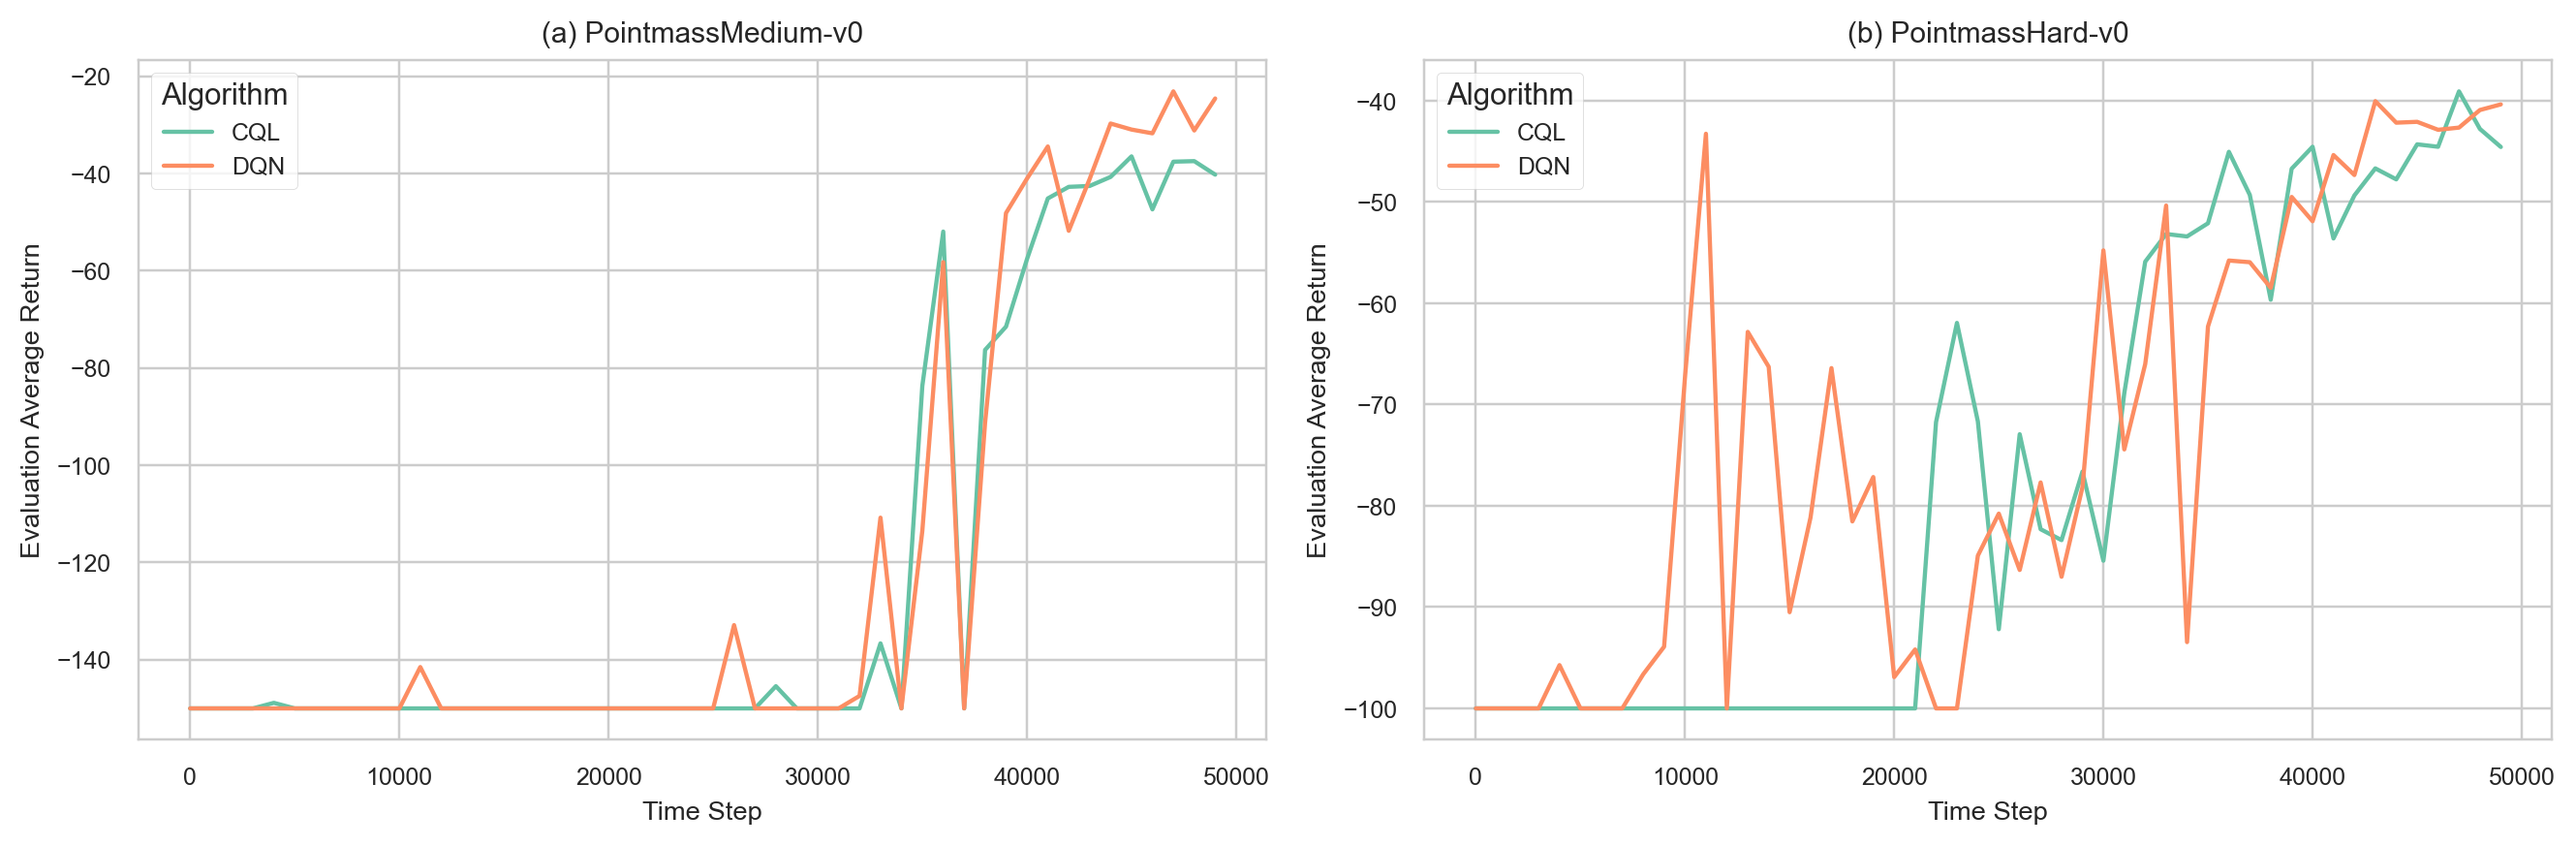

In [21]:
index_map = defaultdict(list)
for file in os.listdir(osp.join(csv_root, 'q3')):
    env_name = file.split('_')[5]
    alg_name = file.split('_')[4]
    index_map[env_name].append([alg_name, file])

fig, axes = plt.subplots(1, len(index_map),
                         figsize=(len(index_map) * 6, 4),
                         dpi=224)
for i, env_name in enumerate(index_map):
    df_list = []
    for alg, file in index_map[env_name]:
        df = pd.read_csv(osp.join(csv_root, 'q3', file),
                         sep=',', encoding='utf-8')
        _process_df(df, 'Evaluation Average Return')
        df['Algorithm'] = alg.upper()
        df_list.append(df)
    data = pd.concat(df_list).sort_values(by='Algorithm')
    axes[i] = sns.lineplot(data=data,   
                           x='Time Step',
                           y='Evaluation Average Return',
                           hue='Algorithm',
                           palette='Set2',
                           ax=axes[i])

    axes[i].set_title(
        f'({chr(97 + i)}) {env_name}'
    )

fig.tight_layout()
fig.savefig(f'../docs/hw5_report/img/q3.png', dpi=600)

## Problem 4: Offline Learning with AWAC

- <input type="checkbox" checked> `PointmassEasy` with unsupervised AWAC
- <input type="checkbox" checked> `PointmassEasy` with supervised AWAC
- <input type="checkbox" checked> `PointmassMedium` with unsupervised AWAC
- <input type="checkbox" checked> `PointmassMedium` with supervised AWAC

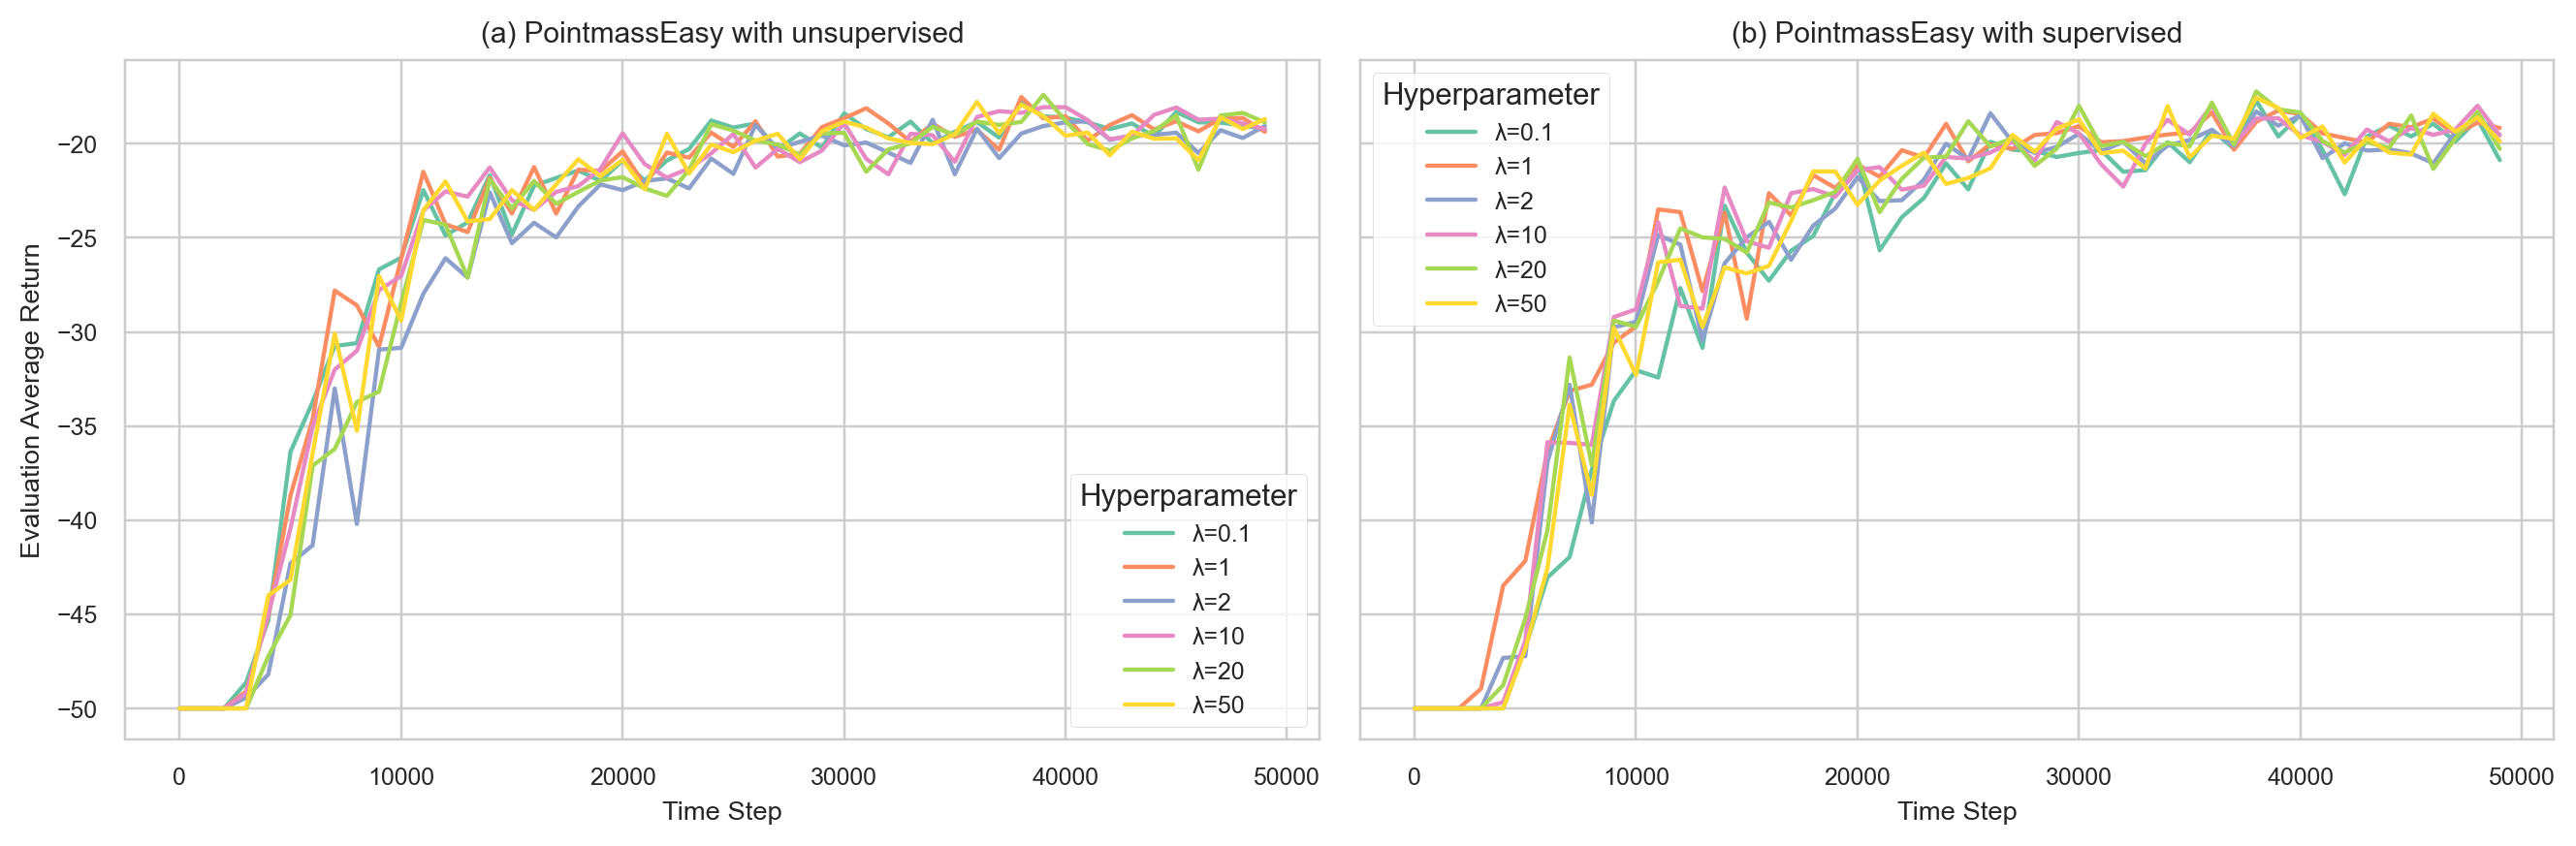

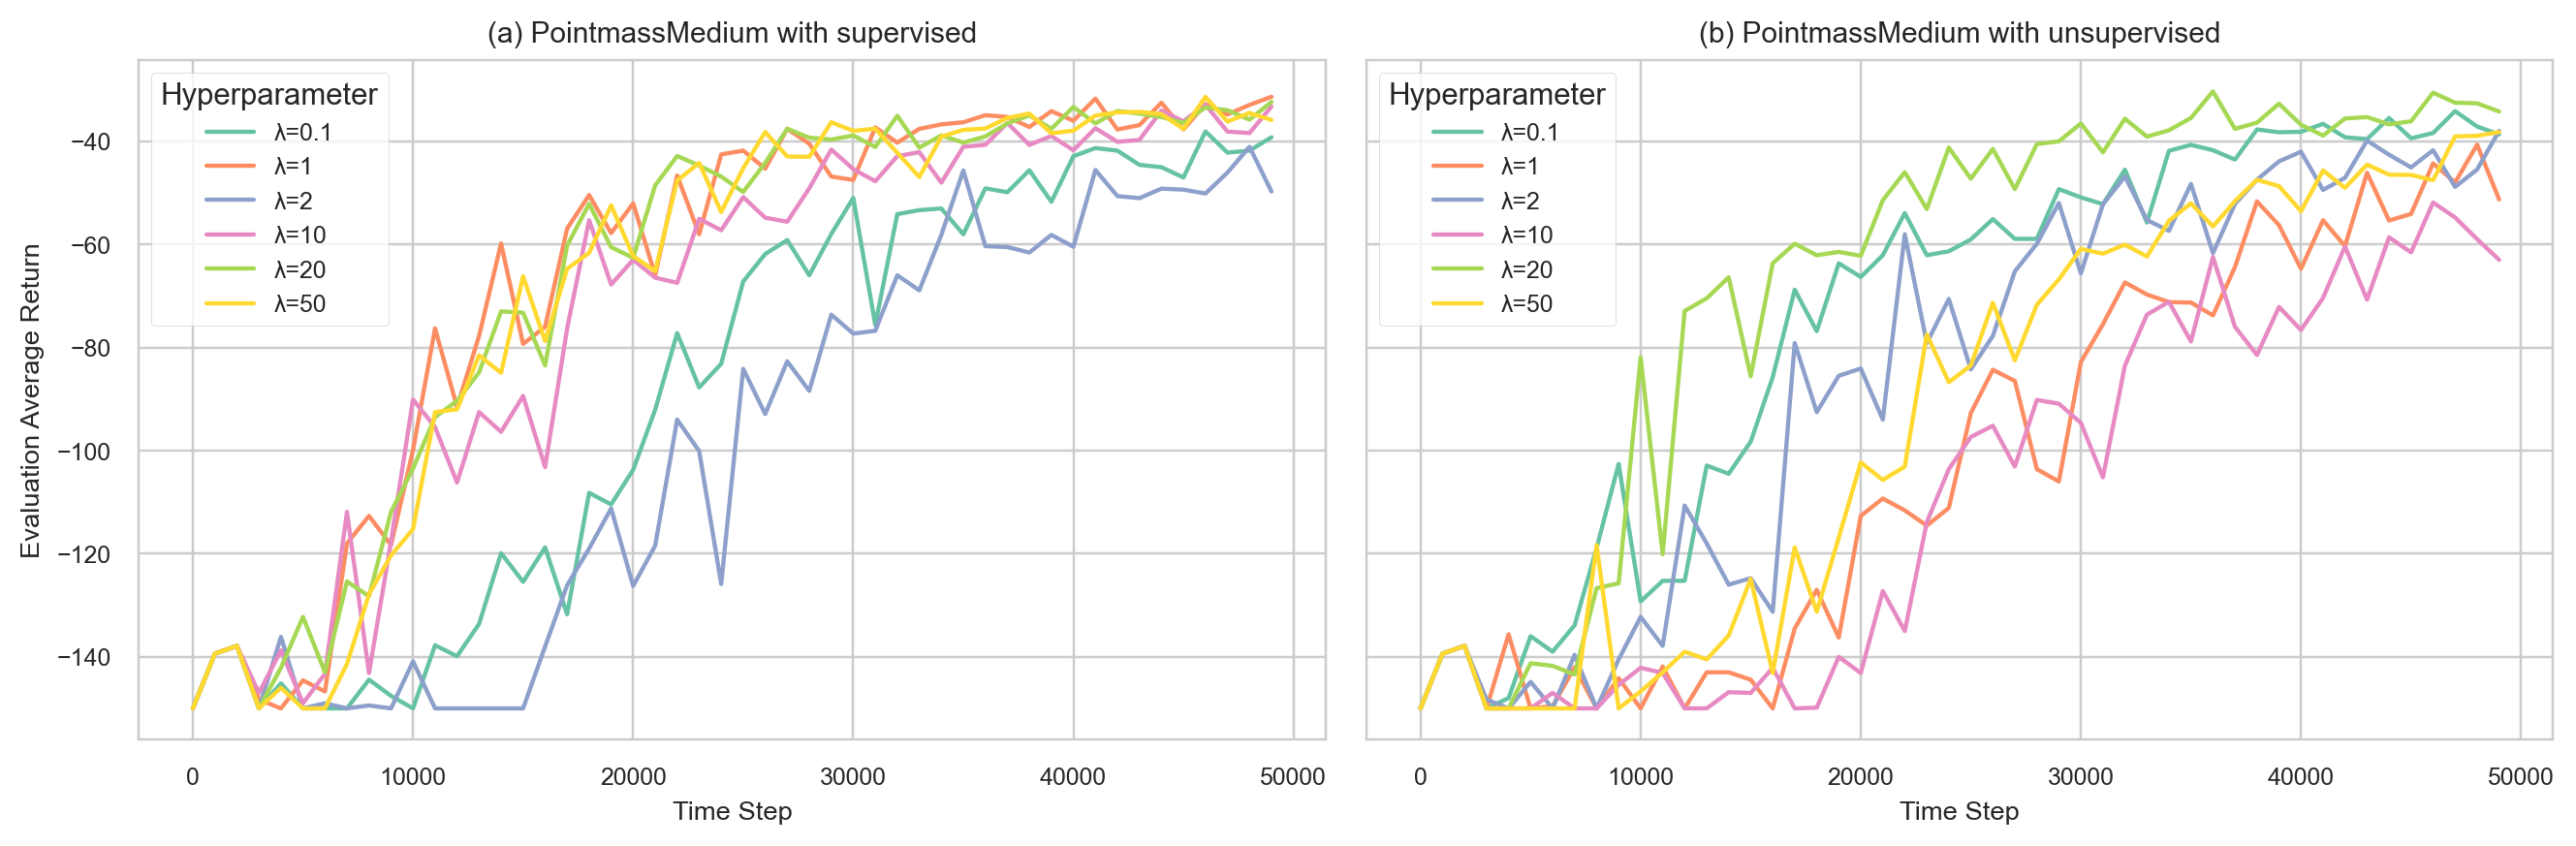

In [9]:
folders = os.listdir(osp.join(csv_root, 'q4'))
index_map = defaultdict(list)

for folder in folders:
    if folder == '.DS_Store':
        continue
    env_name, alg_type = folder.split('_')
    index_map[env_name].append(alg_type)

for env_name, alg_types in index_map.items():
    fig, axes = plt.subplots(1, len(alg_types), sharey=True,
                             figsize=(6 * len(alg_types), 4), dpi=224)
    for i, alg_type in enumerate(alg_types):
        files = os.listdir(
            osp.join(csv_root, 'q4', f'{env_name}_{alg_type}')
        )
        df_list = []
        for file in files:
            lambda_val = file.split('_')[6].split('lam')[1]
            df = pd.read_csv(
                osp.join(csv_root, 'q4', f'{env_name}_{alg_type}', file),
                sep=',', encoding='utf-8'
            )
            _process_df(df, 'Evaluation Average Return')
            df['Hyperparameter'] = f'λ={lambda_val}'
            df['Lambda'] = float(lambda_val)
            df_list.append(df)

        data = pd.concat(df_list).sort_values(by='Lambda')

        axes[i] = sns.lineplot(data=data,
                               x='Time Step',
                               y='Evaluation Average Return',
                               hue='Hyperparameter',
                               palette='Set2',
                               ax=axes[i])
        ename = 'Pointmass' + env_name.capitalize() 
        axes[i].set_title(
            f'({chr(97 + i)}) {ename} with {alg_type}'
        )

    fig.tight_layout()
    fig.savefig(f'../docs/hw5_report/img/q4_{env_name}.png', dpi=600)


## Problem 5: Offline Learning with IQL

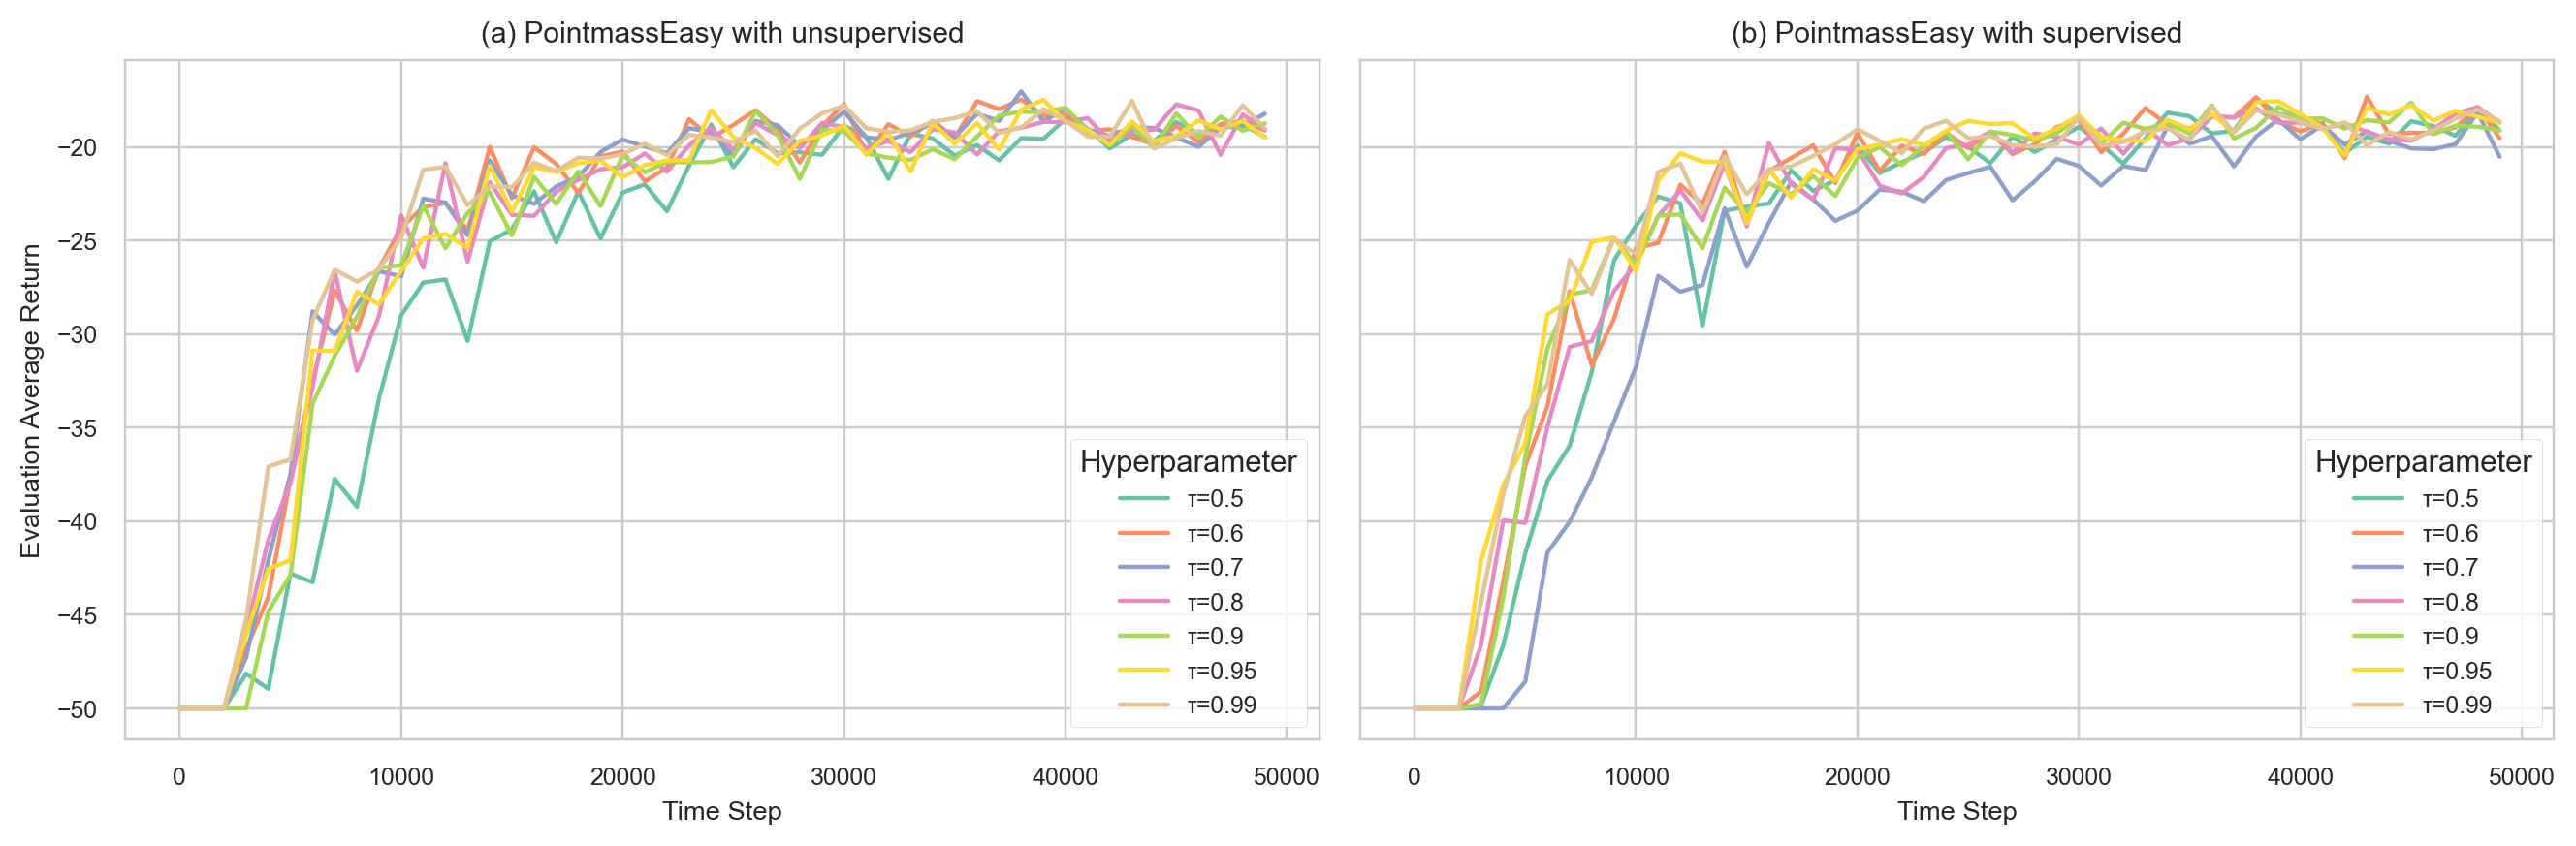

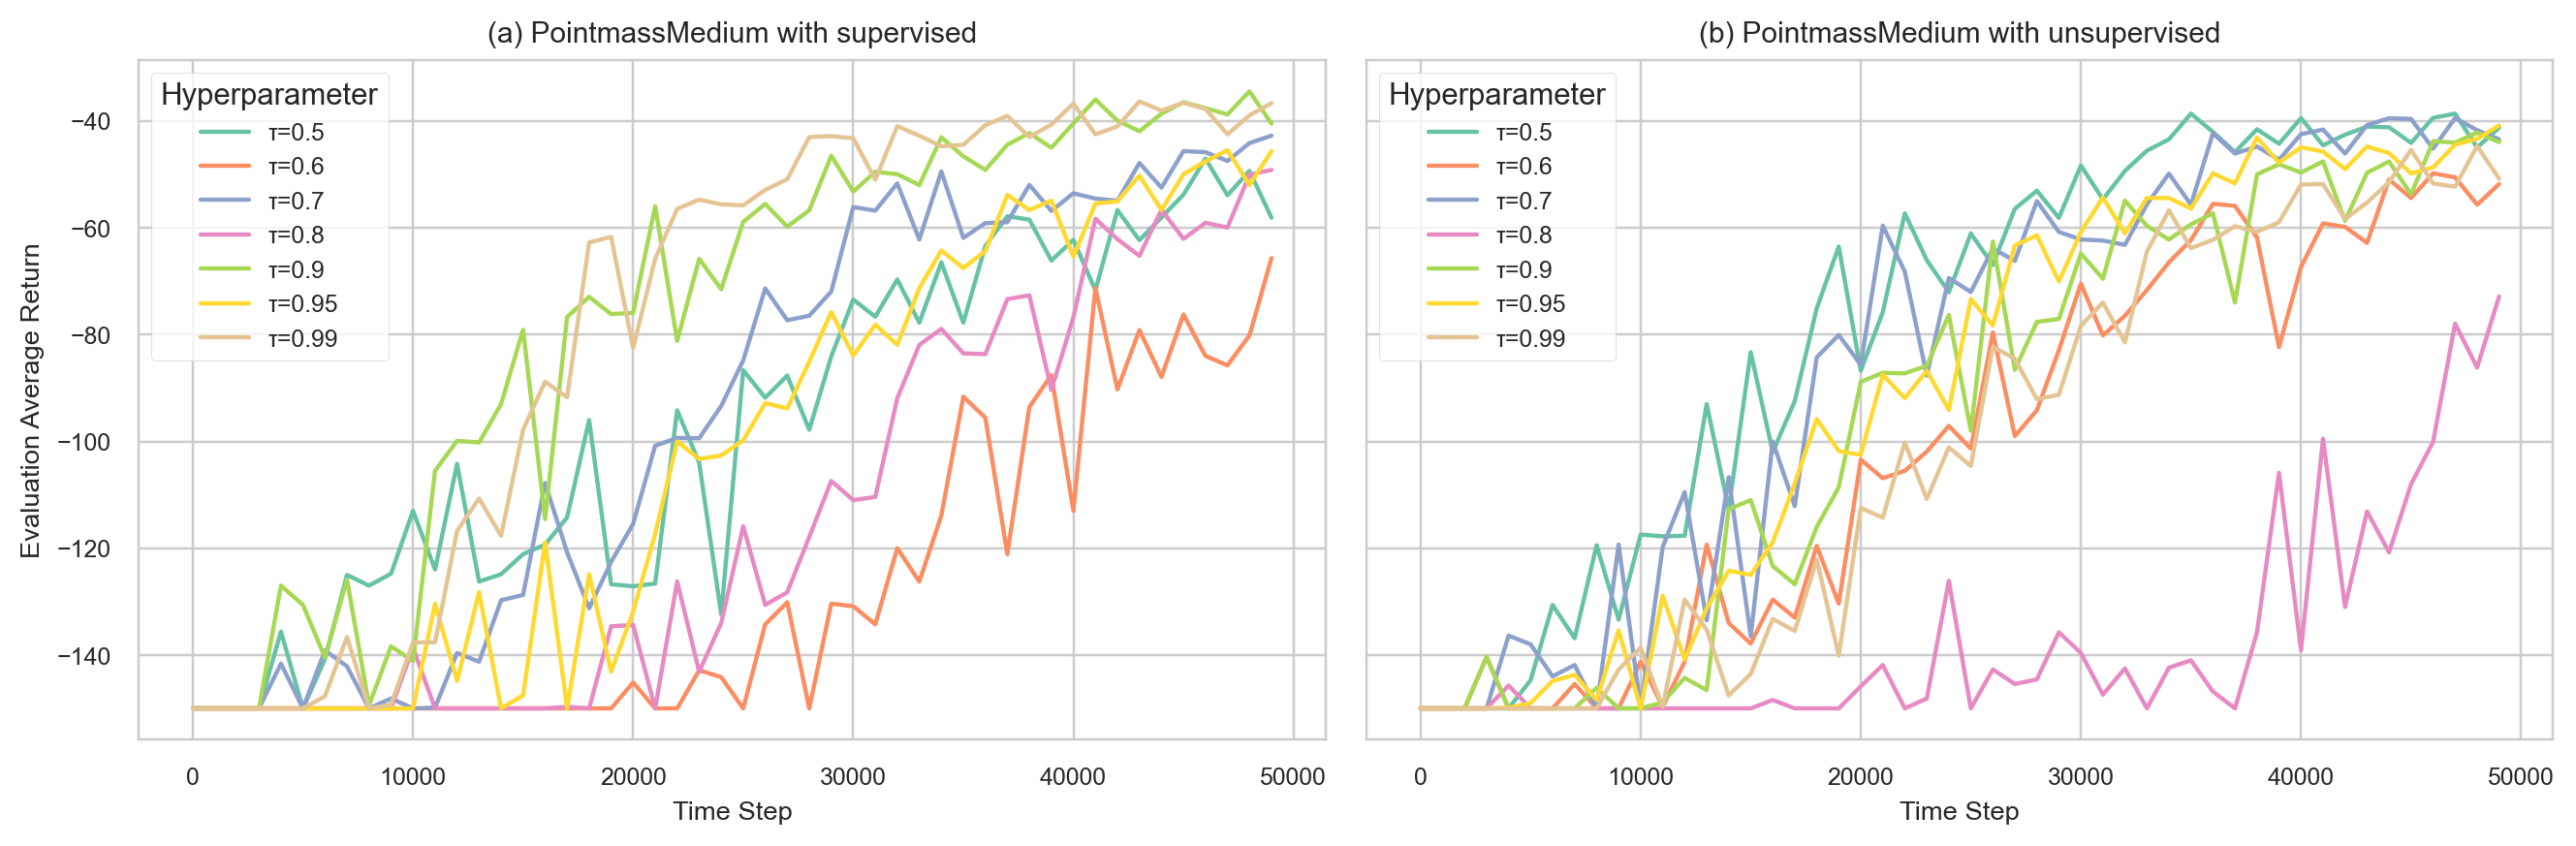

In [12]:
folders = os.listdir(osp.join(csv_root, 'q5'))
index_map = defaultdict(list)

for folder in folders:
    if folder == '.DS_Store':
        continue
    env_name, alg_type = folder.split('_')
    index_map[env_name].append(alg_type)

for env_name, alg_types in index_map.items():
    fig, axes = plt.subplots(1, len(alg_types), sharey=True,
                             figsize=(6 * len(alg_types), 4), dpi=224)
    for i, alg_type in enumerate(alg_types):
        files = os.listdir(
            osp.join(csv_root, 'q5', f'{env_name}_{alg_type}')
        )
        df_list = []
        for file in files:
            tau_val = file.split('_')[7].split('tau')[1]
            df = pd.read_csv(
                osp.join(csv_root, 'q5', f'{env_name}_{alg_type}', file),
                sep=',', encoding='utf-8'
            )
            _process_df(df, 'Evaluation Average Return')
            df['Hyperparameter'] = f'τ={tau_val}'
            df['Tau'] = float(tau_val)
            df_list.append(df)

        data = pd.concat(df_list).sort_values(by='Tau')

        axes[i] = sns.lineplot(data=data,
                               x='Time Step',
                               y='Evaluation Average Return',
                               hue='Hyperparameter',
                               palette='Set2',
                               ax=axes[i])
        ename = 'Pointmass' + env_name.capitalize() 
        axes[i].set_title(
            f'({chr(97 + i)}) {ename} with {alg_type}'
        )

    fig.tight_layout()
    fig.savefig(f'../docs/hw5_report/img/q5_{env_name}.png', dpi=600) 